In [1]:
import os
import sys
import re
import time
import random
import warnings
import collections
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
import seaborn as sns

sys.path.append('../../src')
import cb_utils
import ds_matching

sns.set(style="darkgrid")
pd.options.display.max_columns = 500

%load_ext autoreload
%autoreload 2

### ITC DS Patient Hours Recomendation Model

#### Plan is to train boosted tree model with both sfere features
- Random 10% test set
- Train quartile models
    1. with current hrs
    2. without current hrs
   
Dataset Notes: 
- has only > 0 current hours sferes
- has only the most recent sfere per member

In [2]:
df = pd.read_csv('/Users/bp/workspace/cb/data-analytics/notebooks/data/itc_knn_sfere_features_20230130.csv', low_memory=False)
print(f'{df.shape[0]} samples')
df.head()

2012 samples


,sfere_id,patient_id,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg
0,15970,12450,8,0,47,2,2,2,2,2,0,0,2,NaN,1,0.0,2.0,1,0,1,2,1,0,1,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,6.70,5.10
1,30736,12454,8,0,34,0,3,0,0,0,0,0,0,NaN,1,0.0,2.0,0,0,0,0,0,0,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,5.06,4.08
2,28597,12455,8,0,56,0,0,0,2,2,0,2,0,NaN,0,NaN,NaN,0,0,1,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,13.62,10.23
3,24393,12458,8,1,29,0,0,0,2,3,2,3,3,NaN,1,2.0,2.0,1,1,1,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,29.37,29.37
4,40385,12459,8,1,46,2,2,2,2,2,0,2,3,NaN,0,NaN,NaN,0,0,2,2,2,2,2,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,35.00,32.42


In [3]:
df = ds_matching.add_total_impairment_and_ranks(df)

In [4]:
df.head()

,sfere_id,patient_id,payer_id_ft,group_id_ft,age_ft,transfer_bed_to_chair_ft,transfer_chair_to_standing_ft,mobility_ft,dressing_ft,bathing_ft,eating_ft,grooming_ft,toileting_ft,turn_change_position_ft,has_incontinence_ft,incontinence_type_ft,incontinence_frequency_ft,calling_friends_and_family_ft,articulating_needs_ft,meal_prep_ft,shopping_ft,medication_management_ft,finances_ft,housework_ft,transportation_ft,daily_routine_decisions_ft,comprehension_ft,member_opinion_ft,cleaning_ft,laundry_ft,change_bed_ft,clean_kitchen_ft,clean_home_ft,medical_appointments_ft,work_school_socialize_ft,driving_ft,alert_oriented_self_ft,alert_oriented_place_ft,alert_oriented_day_time_ft,has_alzheimers_ft,has_dementia_ft,reporting_current_hrs_ft,reporting_rec_hrs_tg,total_impairment,impairment_rank,cur_hrs_rank,rec_hrs_rank
0,15970,12450,8,0,47,2,2,2,2,2,0,0,2,NaN,1,0.0,2.0,1,0,1,2,1,0,1,1,0,0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1.0,1.0,1.0,0.0,0.0,6.70,5.10,25.0,0.918986,0.506213,0.491799
1,30736,12454,8,0,34,0,3,0,0,0,0,0,0,NaN,1,0.0,2.0,0,0,0,0,0,0,1,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,5.06,4.08,8.0,0.313618,0.399105,0.409294
2,28597,12455,8,0,56,0,0,0,2,2,0,2,0,NaN,0,NaN,NaN,0,0,1,1,1,1,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,13.62,10.23,11.0,0.510189,0.764662,0.726640
3,24393,12458,8,1,29,0,0,0,2,3,2,3,3,NaN,1,2.0,2.0,1,1,1,1,1,1,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,29.37,29.37,29.0,0.954026,0.979125,0.984592
4,40385,12459,8,1,46,2,2,2,2,2,0,2,3,NaN,0,NaN,NaN,0,0,2,2,2,2,2,2,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1.0,1.0,1.0,0.0,0.0,35.00,32.42,28.0,0.947068,0.988072,0.990308


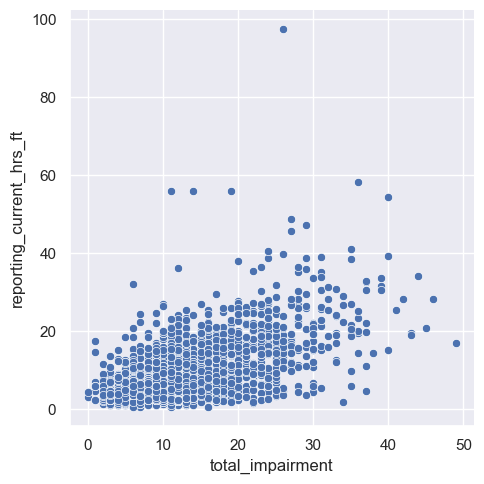

In [5]:
sns.relplot(data=df, x='total_impairment', y='reporting_current_hrs_ft')

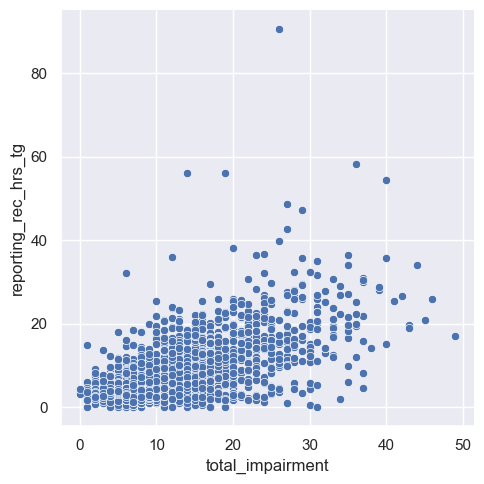

In [6]:
sns.relplot(data=df, x='total_impairment', y='reporting_rec_hrs_tg')

### Features

In [7]:
categorical_features = [
 'transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
    
    # exclude group from features for knn
 # 'group_id_ft'
    
# always blank in itc
 # 'turn_change_position_ft',
 # 'cleaning_ft',
 # 'laundry_ft',
 # 'change_bed_ft',
 # 'clean_kitchen_ft',
 # 'clean_home_ft',
 # 'medical_appointments_ft',
 # 'work_school_socialize_ft',
 # 'is_disabled_ft'
]

cont_features = [
 # 'reporting_current_hrs_ft',
 'age_ft',
]
 

features = categorical_features + cont_features
target = 'reporting_rec_hrs_tg'
categorical_feature_indexes = [i for i in range(len(categorical_features))]

### Patient Similarity model
- Find the k (in this case 10) most similar patients to a single patient within the context of the payer
- Can compare signle patient to mean/median min/max of 10 "neighbors"
- Can also look at the 10 neighbors, see how they are similar

In [8]:
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor

#### These are the dimensions over which we calc similarity

In [9]:
features

['transfer_bed_to_chair_ft',
 'transfer_chair_to_standing_ft',
 'mobility_ft',
 'dressing_ft',
 'bathing_ft',
 'eating_ft',
 'grooming_ft',
 'toileting_ft',
 'has_incontinence_ft',
 'incontinence_type_ft',
 'incontinence_frequency_ft',
 'calling_friends_and_family_ft',
 'articulating_needs_ft',
 'meal_prep_ft',
 'shopping_ft',
 'medication_management_ft',
 'finances_ft',
 'housework_ft',
 'transportation_ft',
 'daily_routine_decisions_ft',
 'comprehension_ft',
 'member_opinion_ft',
 'driving_ft',
 'alert_oriented_self_ft',
 'alert_oriented_place_ft',
 'alert_oriented_day_time_ft',
 'has_alzheimers_ft',
 'has_dementia_ft',
 'age_ft']

In [10]:
df.group_id_ft.value_counts()

 2    1541
 0     364
 1      82
-1      25
Name: group_id_ft, dtype: int64

In [11]:
neighbors = {}
distances = {}
k = 100

x_train = df[features]

pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('scaler', preprocessing.RobustScaler())])
pipe.fit(x_train)
x = pipe.transform(x_train)
nn = NearestNeighbors(n_neighbors=k).fit(x)
dists, nn_idxs = nn.kneighbors()

# get patient_ids
for i, (nn_idx, dist) in enumerate(zip(nn_idxs, dists)): 
    neighbors[df.iloc[i].patient_id] = df.iloc[nn_idx].patient_id.values
    distances[df.iloc[i].patient_id] = dist

In [12]:
rows = []
for pid in df.patient_id.unique():
    pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
    p = df.loc[df.patient_id == pid]
    dists = distances[pid]
    
    rows.append([pid,
                 p.reporting_current_hrs_ft.mean(),
                 p.reporting_rec_hrs_tg.mean(),
                 dists.mean(),
                 dists.std(),
                 pid_neighbors.reporting_rec_hrs_tg.mean(),
                 pid_neighbors.reporting_rec_hrs_tg.quantile(.1),
                 pid_neighbors.reporting_rec_hrs_tg.quantile(.25),
                 pid_neighbors.reporting_rec_hrs_tg.median(),
                 pid_neighbors.reporting_rec_hrs_tg.quantile(.75),
                 pid_neighbors.reporting_rec_hrs_tg.quantile(.9),
                 pid_neighbors.reporting_rec_hrs_tg.std(),
                 pid_neighbors.reporting_rec_hrs_tg.min(),
                 pid_neighbors.reporting_rec_hrs_tg.max(),
                 pid_neighbors.reporting_rec_hrs_tg,
                 dists,
                 neighbors[pid]
                ])
nn_df = pd.DataFrame(rows, columns=[
    'patient_id',
    'cur_hrs',
    'rec_hrs',
    'mean_distance_from_nn',
    'std_distance_from_nn',
    'rec_hrs_mean_nn',
    'rec_hrs_pct_10_nn',
    'rec_hrs_pct_25_nn',
    'rec_hrs_pct_50_nn',
    'rec_hrs_pct_75_nn',
    'rec_hrs_pct_90_nn',
    'rec_hrs_std_nn',
    'rec_hrs_min_nn',
    'rec_hrs_max_nn' ,
    'rec_hrs_from_nn',
    'distances_from_nn',
    'nn_patient_ids'
]) 
nn_df.head()

,patient_id,cur_hrs,rec_hrs,mean_distance_from_nn,std_distance_from_nn,rec_hrs_mean_nn,rec_hrs_pct_10_nn,rec_hrs_pct_25_nn,rec_hrs_pct_50_nn,rec_hrs_pct_75_nn,rec_hrs_pct_90_nn,rec_hrs_std_nn,rec_hrs_min_nn,rec_hrs_max_nn,rec_hrs_from_nn,distances_from_nn,nn_patient_ids
0,12450,6.70,5.10,4.071038,0.314338,15.3537,4.310,8.4800,14.000,20.5900,25.806,11.349017,0.57,90.63,4 32.42 5 31.61 15 32.42 18 ...,"[3.0661231402393327, 3.079682523320293, 3.2188...","[18567, 15288, 22787, 19243, 19857, 15319, 163..."
1,12454,5.06,4.08,4.020337,0.357119,4.6660,1.709,2.3525,3.795,6.0300,9.186,3.175073,0.00,14.66,16 5.06 19 1.72 38 7.33 43 ...,"[2.039607805437114, 2.179704363236241, 2.67415...","[12658, 12907, 15071, 12778, 13148, 22787, 133..."
2,12455,13.62,10.23,2.266138,0.208161,8.2648,2.300,3.9050,7.185,11.6250,16.562,5.245998,1.03,23.65,17 2.30 40 7.53 59 7.13 62 ...,"[1.6944353369518441, 1.72272394125634, 1.73333...","[19108, 13184, 13285, 16338, 13254, 15152, 126..."
3,12458,29.37,29.37,4.800241,0.373542,12.6686,4.224,7.1150,12.000,16.3600,23.407,7.299997,1.69,32.00,12 30.75 20 27.00 28 14.48 29 ...,"[3.640054944640259, 3.678918923331206, 3.80847...","[12511, 23200, 13291, 12834, 12993, 22949, 124..."
4,12459,35.00,32.42,3.900591,0.440932,18.0035,8.160,11.9750,16.265,22.0325,26.729,10.884140,1.03,90.63,0 5.10 13 12.13 18 19.42 23 ...,"[2.154065922853802, 2.8759539480163987, 2.8965...","[13134, 14330, 13328, 12544, 14262, 13420, 127..."


In [13]:
# calc ranges and mean abs error
nn_df = nn_df.assign(in_min_max_range=np.where((nn_df.rec_hrs >= nn_df.rec_hrs_min_nn) & (nn_df.rec_hrs <= nn_df.rec_hrs_max_nn), 1, 0),
                     in_10_90_range=np.where((nn_df.rec_hrs >= nn_df.rec_hrs_pct_10_nn) & (nn_df.rec_hrs <= nn_df.rec_hrs_pct_90_nn), 1, 0),
                     in_25_75=np.where((nn_df.rec_hrs >= nn_df.rec_hrs_pct_25_nn) & (nn_df.rec_hrs <= nn_df.rec_hrs_pct_75_nn), 1, 0),
                     hrs_range=nn_df.rec_hrs_max_nn - nn_df.rec_hrs_min_nn)

nn_df = nn_df.assign(mean_err=np.abs(nn_df.rec_hrs_mean_nn - nn_df.rec_hrs), median_err=np.abs(nn_df.rec_hrs_pct_50_nn - nn_df.rec_hrs))

In [14]:
nn_df.head()

,patient_id,cur_hrs,rec_hrs,mean_distance_from_nn,std_distance_from_nn,rec_hrs_mean_nn,rec_hrs_pct_10_nn,rec_hrs_pct_25_nn,rec_hrs_pct_50_nn,rec_hrs_pct_75_nn,rec_hrs_pct_90_nn,rec_hrs_std_nn,rec_hrs_min_nn,rec_hrs_max_nn,rec_hrs_from_nn,distances_from_nn,nn_patient_ids,in_min_max_range,in_10_90_range,in_25_75,hrs_range,mean_err,median_err
0,12450,6.70,5.10,4.071038,0.314338,15.3537,4.310,8.4800,14.000,20.5900,25.806,11.349017,0.57,90.63,4 32.42 5 31.61 15 32.42 18 ...,"[3.0661231402393327, 3.079682523320293, 3.2188...","[18567, 15288, 22787, 19243, 19857, 15319, 163...",1,1,0,90.06,10.2537,8.900
1,12454,5.06,4.08,4.020337,0.357119,4.6660,1.709,2.3525,3.795,6.0300,9.186,3.175073,0.00,14.66,16 5.06 19 1.72 38 7.33 43 ...,"[2.039607805437114, 2.179704363236241, 2.67415...","[12658, 12907, 15071, 12778, 13148, 22787, 133...",1,1,1,14.66,0.5860,0.285
2,12455,13.62,10.23,2.266138,0.208161,8.2648,2.300,3.9050,7.185,11.6250,16.562,5.245998,1.03,23.65,17 2.30 40 7.53 59 7.13 62 ...,"[1.6944353369518441, 1.72272394125634, 1.73333...","[19108, 13184, 13285, 16338, 13254, 15152, 126...",1,1,1,22.62,1.9652,3.045
3,12458,29.37,29.37,4.800241,0.373542,12.6686,4.224,7.1150,12.000,16.3600,23.407,7.299997,1.69,32.00,12 30.75 20 27.00 28 14.48 29 ...,"[3.640054944640259, 3.678918923331206, 3.80847...","[12511, 23200, 13291, 12834, 12993, 22949, 124...",1,0,0,30.31,16.7014,17.370
4,12459,35.00,32.42,3.900591,0.440932,18.0035,8.160,11.9750,16.265,22.0325,26.729,10.884140,1.03,90.63,0 5.10 13 12.13 18 19.42 23 ...,"[2.154065922853802, 2.8759539480163987, 2.8965...","[13134, 14330, 13328, 12544, 14262, 13420, 127...",1,0,0,89.60,14.4165,16.155


In [15]:
print(f'Percent rec hrs in min max neighbors range: {nn_df.in_min_max_range.sum() * 100 / nn_df.shape[0]}')
print(f'Percent rec hrs in 10-90 neighbors range: {nn_df.in_10_90_range.sum() * 100 / nn_df.shape[0]}')
print(f'Percent rec hrs in 25-75 neighbors range: {nn_df.in_25_75.sum() * 100 / nn_df.shape[0]}')

Percent rec hrs in min max neighbors range: 98.40954274353876
Percent rec hrs in 10-90 neighbors range: 79.87077534791253
Percent rec hrs in 25-75 neighbors range: 49.60238568588469


In [16]:
(nn_df.rec_hrs.sum() - nn_df.rec_hrs_mean_nn.sum())

1480.691999999999

In [17]:
(nn_df.rec_hrs - nn_df.rec_hrs_mean_nn).mean()

0.7359304174950301

In [18]:
nn_df.shape

(2012, 23)

### Tool up

In [19]:
def build_neighborhood(df, k=100):
    neighbors = {}
    distances = {}
    x_train = df[features]

    pipe = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('scaler', preprocessing.RobustScaler())])
    pipe.fit(x_train)
    x = pipe.transform(x_train)
    nn = NearestNeighbors(n_neighbors=k).fit(x)
    dists, nn_idxs = nn.kneighbors()

    # get patient_ids
    for i, (nn_idx, dist) in enumerate(zip(nn_idxs, dists)): 
        neighbors[df.iloc[i].patient_id] = df.iloc[nn_idx].patient_id.values
        distances[df.iloc[i].patient_id] = dist

    rows = []
    for pid in df.patient_id.unique():
        pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
        p = df.loc[df.patient_id == pid]
        dists = distances[pid]

        rows.append([pid,
                     p.reporting_current_hrs_ft.mean(),
                     p.reporting_rec_hrs_tg.mean(),
                     dists.mean(),
                     dists.std(),
                     pid_neighbors.reporting_rec_hrs_tg.mean(),
                     pid_neighbors.reporting_rec_hrs_tg.quantile(.1),
                     pid_neighbors.reporting_rec_hrs_tg.quantile(.25),
                     pid_neighbors.reporting_rec_hrs_tg.median(),
                     pid_neighbors.reporting_rec_hrs_tg.quantile(.75),
                     pid_neighbors.reporting_rec_hrs_tg.quantile(.9),
                     pid_neighbors.reporting_rec_hrs_tg.std(),
                     pid_neighbors.reporting_rec_hrs_tg.min(),
                     pid_neighbors.reporting_rec_hrs_tg.max(),
                     pid_neighbors.reporting_rec_hrs_tg,
                     pid_neighbors.reporting_current_hrs_ft.mean(),
                     pid_neighbors.reporting_current_hrs_ft.quantile(.1),
                     pid_neighbors.reporting_current_hrs_ft.quantile(.25),
                     pid_neighbors.reporting_current_hrs_ft.median(),
                     pid_neighbors.reporting_current_hrs_ft.quantile(.75),
                     pid_neighbors.reporting_current_hrs_ft.quantile(.9),
                     pid_neighbors.reporting_current_hrs_ft.std(),
                     pid_neighbors.reporting_current_hrs_ft.min(),
                     pid_neighbors.reporting_current_hrs_ft.max(),
                     pid_neighbors.reporting_current_hrs_ft,
                     dists,
                     neighbors[pid]
                    ])
    nn_df = pd.DataFrame(rows, columns=[
        'patient_id',
        'cur_hrs',
        'rec_hrs',
        'mean_distance_from_nn',
        'std_distance_from_nn',
        'rec_hrs_mean_nn',
        'rec_hrs_pct_10_nn',
        'rec_hrs_pct_25_nn',
        'rec_hrs_pct_50_nn',
        'rec_hrs_pct_75_nn',
        'rec_hrs_pct_90_nn',
        'rec_hrs_std_nn',
        'rec_hrs_min_nn',
        'rec_hrs_max_nn' ,
        'rec_hrs_from_nn',
        'cur_hrs_mean_nn',
        'cur_hrs_pct_10_nn',
        'cur_hrs_pct_25_nn',
        'cur_hrs_pct_50_nn',
        'cur_hrs_pct_75_nn',
        'cur_hrs_pct_90_nn',
        'cur_hrs_std_nn',
        'cur_hrs_min_nn',
        'cur_hrs_max_nn' ,
        'cur_hrs_from_nn',
        'distances_from_nn',
        'nn_patient_ids'
    ]) 

    # calc ranges and mean abs error
    nn_df = nn_df.assign(in_min_max_range=np.where((nn_df.rec_hrs >= nn_df.rec_hrs_min_nn) & (nn_df.rec_hrs <= nn_df.rec_hrs_max_nn), 1, 0),
                         in_10_90_range=np.where((nn_df.rec_hrs >= nn_df.rec_hrs_pct_10_nn) & (nn_df.rec_hrs <= nn_df.rec_hrs_pct_90_nn), 1, 0),
                         in_25_75=np.where((nn_df.rec_hrs >= nn_df.rec_hrs_pct_25_nn) & (nn_df.rec_hrs <= nn_df.rec_hrs_pct_75_nn), 1, 0),
                         hrs_range=nn_df.rec_hrs_max_nn - nn_df.rec_hrs_min_nn)

    nn_df = nn_df.assign(mean_err=np.abs(nn_df.rec_hrs_mean_nn - nn_df.rec_hrs), median_err=np.abs(nn_df.rec_hrs_pct_50_nn - nn_df.rec_hrs))


    print(f'Percent rec hrs in min max neighbors range: {nn_df.in_min_max_range.sum() * 100 / nn_df.shape[0]}')
    print(f'Percent rec hrs in 10-90 neighbors range: {nn_df.in_10_90_range.sum() * 100 / nn_df.shape[0]}')
    print(f'Percent rec hrs in 25-75 neighbors range: {nn_df.in_25_75.sum() * 100 / nn_df.shape[0]}')

    print(f'Total reduction of hrs from recs: {(nn_df.rec_hrs.sum() - nn_df.rec_hrs_mean_nn.sum())}')
    print(f'Avg reduction of hrs from recs: {(nn_df.rec_hrs - nn_df.rec_hrs_mean_nn).mean()}')
    
    return nn_df


In [20]:
nn_100 = build_neighborhood(df, 100)

Percent rec hrs in min max neighbors range: 98.40954274353876
Percent rec hrs in 10-90 neighbors range: 79.87077534791253
Percent rec hrs in 25-75 neighbors range: 49.60238568588469
Total reduction of hrs from recs: 1480.691999999999
Avg reduction of hrs from recs: 0.7359304174950301


In [21]:
nn_50 = build_neighborhood(df, 50)

Percent rec hrs in min max neighbors range: 96.66998011928429
Percent rec hrs in 10-90 neighbors range: 78.47912524850895
Percent rec hrs in 25-75 neighbors range: 48.75745526838966
Total reduction of hrs from recs: 1226.5238999999983
Avg reduction of hrs from recs: 0.609604324055666


In [22]:
nn_25 = build_neighborhood(df, 25)

Percent rec hrs in min max neighbors range: 92.69383697813122
Percent rec hrs in 10-90 neighbors range: 75.19880715705766
Percent rec hrs in 25-75 neighbors range: 47.514910536779325
Total reduction of hrs from recs: 931.1768000000011
Avg reduction of hrs from recs: 0.46281153081510934


In [24]:
nn_25.to_csv('../data/itc_25_knn_20230131.csv', index=False)
nn_50.to_csv('../data/itc_50_knn_20230131.csv', index=False)
nn_100.to_csv('../data/itc_100_knn_20230131.csv', index=False)

In [25]:
nn_25.head()

,patient_id,cur_hrs,rec_hrs,mean_distance_from_nn,std_distance_from_nn,rec_hrs_mean_nn,rec_hrs_pct_10_nn,rec_hrs_pct_25_nn,rec_hrs_pct_50_nn,rec_hrs_pct_75_nn,rec_hrs_pct_90_nn,rec_hrs_std_nn,rec_hrs_min_nn,rec_hrs_max_nn,rec_hrs_from_nn,cur_hrs_mean_nn,cur_hrs_pct_10_nn,cur_hrs_pct_25_nn,cur_hrs_pct_50_nn,cur_hrs_pct_75_nn,cur_hrs_pct_90_nn,cur_hrs_std_nn,cur_hrs_min_nn,cur_hrs_max_nn,cur_hrs_from_nn,distances_from_nn,nn_patient_ids,in_min_max_range,in_10_90_range,in_25_75,hrs_range,mean_err,median_err
0,12450,6.70,5.10,3.630909,0.253787,17.3908,6.452,9.94,14.00,20.32,25.760,16.966045,0.57,90.63,32 11.49 52 16.15 56 8.39 113 ...,20.1664,7.818,10.75,16.70,22.75,30.356,18.275048,4.25,97.52,32 18.85 52 19.89 56 10.57 113 ...,"[3.0661231402393327, 3.079682523320293, 3.2188...","[18567, 15288, 22787, 19243, 19857, 15319, 163...",1,0,0,90.06,12.2908,8.90
1,12454,5.06,4.08,3.620007,0.515442,5.1424,2.300,2.59,4.02,6.03,10.566,3.616078,2.07,14.66,43 5.08 60 14.37 91 2.30 95 ...,6.0476,2.368,3.05,4.89,7.45,12.046,4.175390,2.30,17.87,43 6.77 60 14.37 91 2.30 95 ...,"[2.039607805437114, 2.179704363236241, 2.67415...","[12658, 12907, 15071, 12778, 13148, 22787, 133...",1,1,1,12.59,1.0624,0.06
2,12455,13.62,10.23,1.968819,0.170543,8.6864,2.990,4.60,7.53,11.09,17.468,5.272114,1.15,19.00,40 7.53 67 8.00 147 5.52 150 ...,9.7860,3.670,5.29,10.75,12.99,16.584,4.934910,2.30,19.00,40 7.53 67 11.00 147 13.91 150 ...,"[1.6944353369518441, 1.72272394125634, 1.73333...","[19108, 13184, 13285, 16338, 15152, 13254, 126...",1,1,1,17.85,1.5436,2.70
3,12458,29.37,29.37,4.261395,0.319343,15.2124,6.452,11.09,13.56,16.03,27.318,7.659122,4.50,32.00,12 30.75 20 27.00 28 14.48 31 ...,17.0640,7.416,11.20,16.03,18.85,32.288,9.575373,4.50,40.40,12 35.46 20 27.00 28 18.85 31 ...,"[3.640054944640259, 3.678918923331206, 3.80847...","[12511, 23200, 13291, 12834, 12993, 22949, 124...",1,0,0,27.50,14.1576,15.81
4,12459,35.00,32.42,3.295712,0.359841,17.0908,8.528,13.10,16.95,20.32,26.668,7.163189,1.03,27.82,18 19.42 27 10.46 47 26.81 52 ...,19.7912,11.002,18.22,19.83,22.75,26.774,6.004341,6.55,30.40,18 19.42 27 13.05 47 26.81 52 ...,"[2.154065922853802, 2.8759539480163987, 2.8965...","[13134, 14330, 13328, 12544, 14262, 13420, 127...",0,0,0,26.79,15.3292,15.47


s patient_id                                                           12450
cur_hrs                                                                6.7
rec_hrs                                                                5.1
mean_distance_from_nn                                             4.071038
std_distance_from_nn                                              0.314338
rec_hrs_mean_nn                                                    15.3537
rec_hrs_pct_10_nn                                                     4.31
rec_hrs_pct_25_nn                                                     8.48
rec_hrs_pct_50_nn                                                     14.0
rec_hrs_pct_75_nn                                                    20.59
rec_hrs_pct_90_nn                                                   25.806
rec_hrs_std_nn                                                   11.349017
rec_hrs_min_nn                                                        0.57
rec_hrs_max_nn         

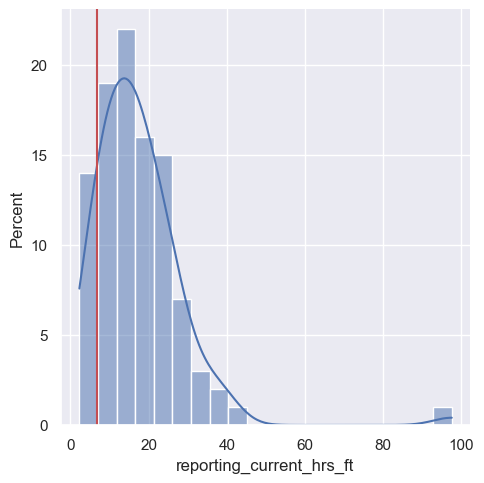

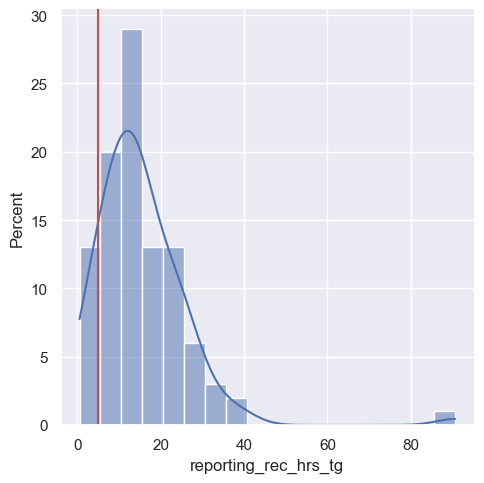

s patient_id                                                           12454
cur_hrs                                                               5.06
rec_hrs                                                               4.08
mean_distance_from_nn                                             4.020337
std_distance_from_nn                                              0.357119
rec_hrs_mean_nn                                                      4.666
rec_hrs_pct_10_nn                                                    1.709
rec_hrs_pct_25_nn                                                   2.3525
rec_hrs_pct_50_nn                                                    3.795
rec_hrs_pct_75_nn                                                     6.03
rec_hrs_pct_90_nn                                                    9.186
rec_hrs_std_nn                                                    3.175073
rec_hrs_min_nn                                                         0.0
rec_hrs_max_nn         

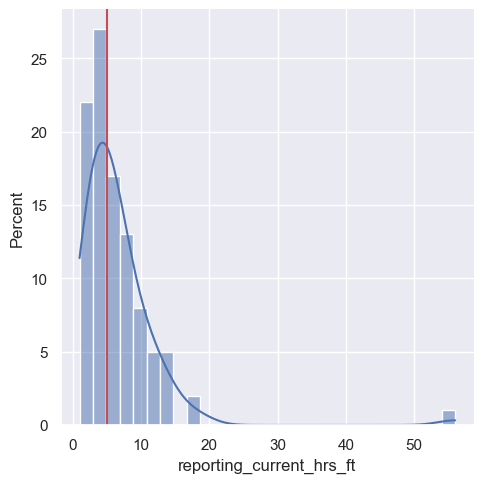

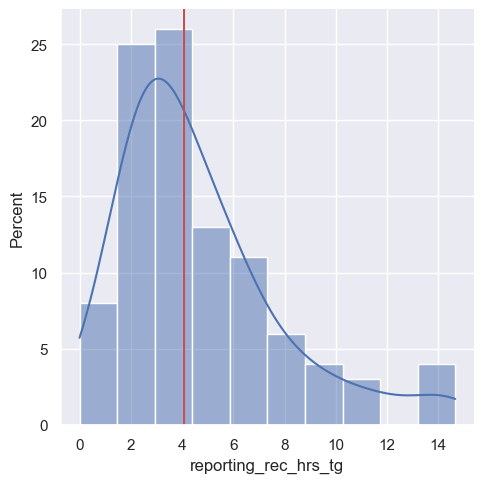

s patient_id                                                           12455
cur_hrs                                                              13.62
rec_hrs                                                              10.23
mean_distance_from_nn                                             2.266138
std_distance_from_nn                                              0.208161
rec_hrs_mean_nn                                                     8.2648
rec_hrs_pct_10_nn                                                      2.3
rec_hrs_pct_25_nn                                                    3.905
rec_hrs_pct_50_nn                                                    7.185
rec_hrs_pct_75_nn                                                   11.625
rec_hrs_pct_90_nn                                                   16.562
rec_hrs_std_nn                                                    5.245998
rec_hrs_min_nn                                                        1.03
rec_hrs_max_nn         

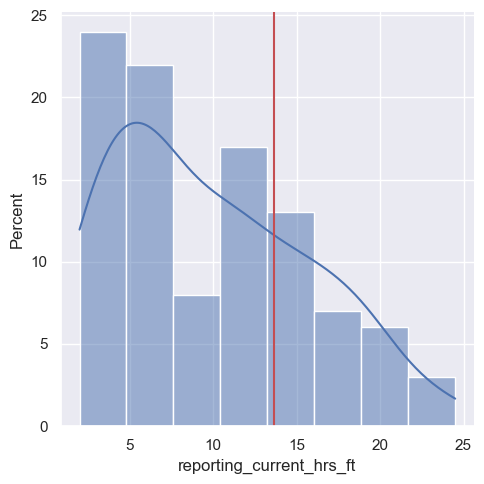

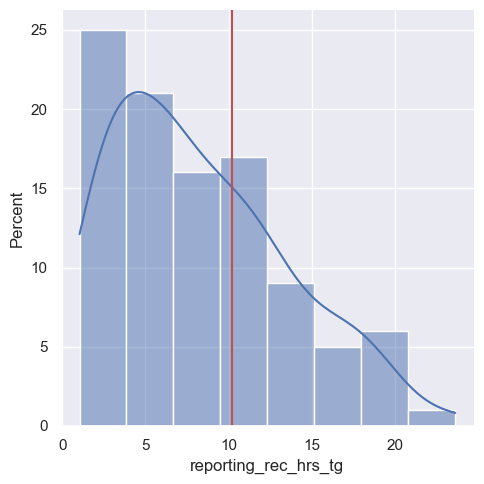

s patient_id                                                           12458
cur_hrs                                                              29.37
rec_hrs                                                              29.37
mean_distance_from_nn                                             4.800241
std_distance_from_nn                                              0.373542
rec_hrs_mean_nn                                                    12.6686
rec_hrs_pct_10_nn                                                    4.224
rec_hrs_pct_25_nn                                                    7.115
rec_hrs_pct_50_nn                                                     12.0
rec_hrs_pct_75_nn                                                    16.36
rec_hrs_pct_90_nn                                                   23.407
rec_hrs_std_nn                                                    7.299997
rec_hrs_min_nn                                                        1.69
rec_hrs_max_nn         

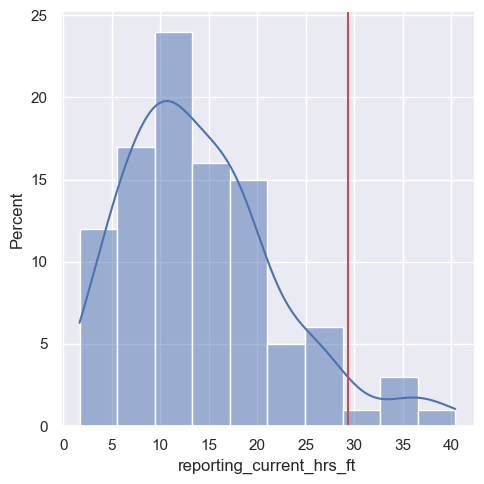

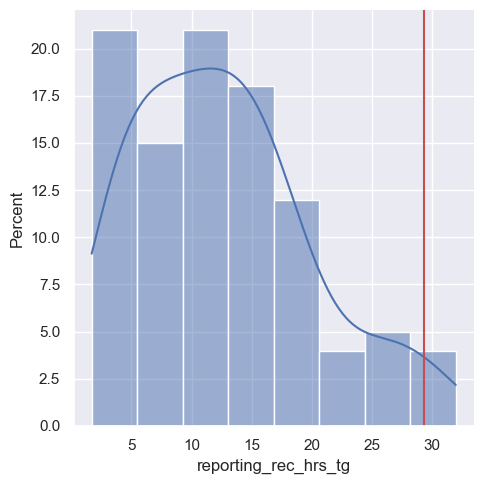

s patient_id                                                           12459
cur_hrs                                                               35.0
rec_hrs                                                              32.42
mean_distance_from_nn                                             3.900591
std_distance_from_nn                                              0.440932
rec_hrs_mean_nn                                                    18.0035
rec_hrs_pct_10_nn                                                     8.16
rec_hrs_pct_25_nn                                                   11.975
rec_hrs_pct_50_nn                                                   16.265
rec_hrs_pct_75_nn                                                  22.0325
rec_hrs_pct_90_nn                                                   26.729
rec_hrs_std_nn                                                    10.88414
rec_hrs_min_nn                                                        1.03
rec_hrs_max_nn         

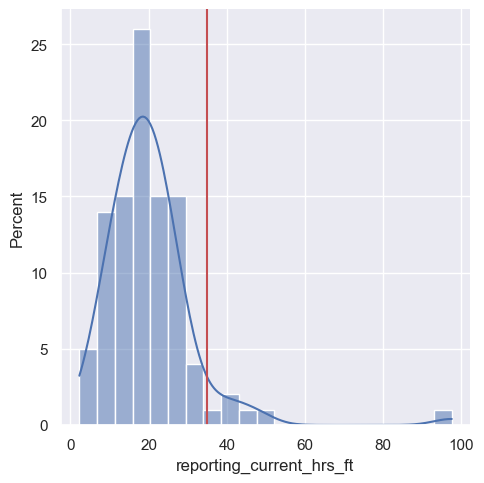

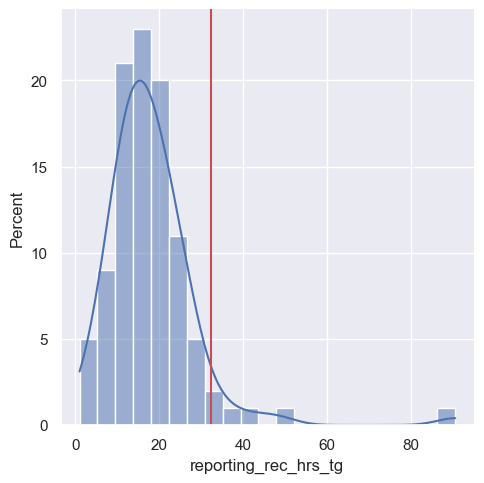

s patient_id                                                           12461
cur_hrs                                                              35.06
rec_hrs                                                              31.61
mean_distance_from_nn                                             4.515636
std_distance_from_nn                                              0.590422
rec_hrs_mean_nn                                                    17.3642
rec_hrs_pct_10_nn                                                    3.324
rec_hrs_pct_25_nn                                                   9.7275
rec_hrs_pct_50_nn                                                     15.0
rec_hrs_pct_75_nn                                                   22.075
rec_hrs_pct_90_nn                                                    32.58
rec_hrs_std_nn                                                   13.808712
rec_hrs_min_nn                                                         0.0
rec_hrs_max_nn         

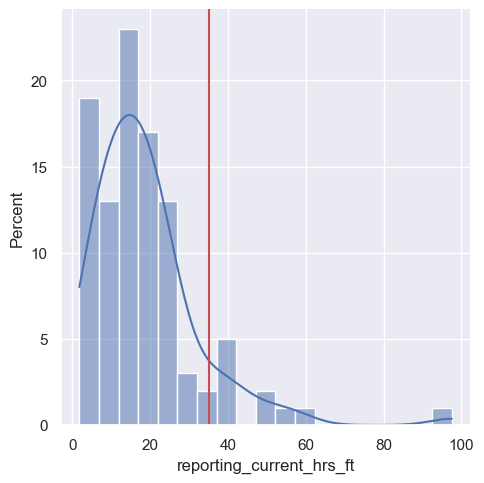

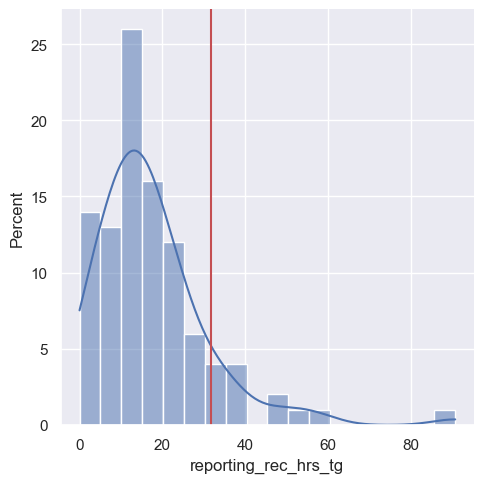

s patient_id                                                           12462
cur_hrs                                                               15.0
rec_hrs                                                              11.15
mean_distance_from_nn                                             2.294279
std_distance_from_nn                                              0.228681
rec_hrs_mean_nn                                                    10.0383
rec_hrs_pct_10_nn                                                    3.032
rec_hrs_pct_25_nn                                                   5.6675
rec_hrs_pct_50_nn                                                    9.225
rec_hrs_pct_75_nn                                                  13.7525
rec_hrs_pct_90_nn                                                   17.099
rec_hrs_std_nn                                                    6.986221
rec_hrs_min_nn                                                        1.03
rec_hrs_max_nn         

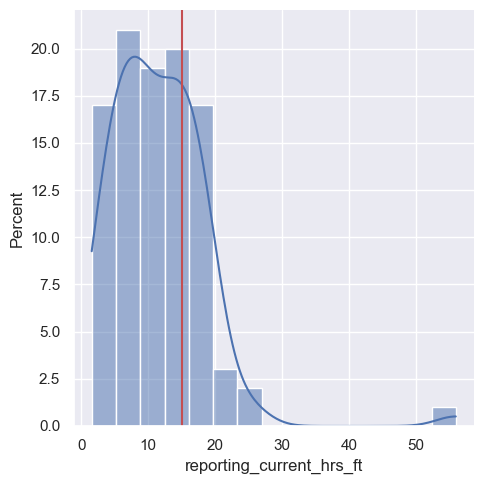

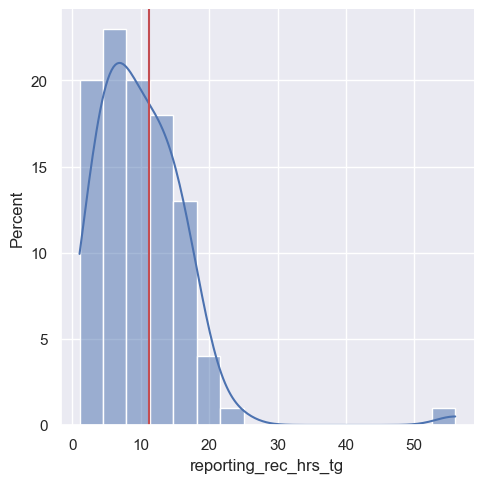

s patient_id                                                           12463
cur_hrs                                                              12.82
rec_hrs                                                               8.45
mean_distance_from_nn                                             2.003374
std_distance_from_nn                                              0.177834
rec_hrs_mean_nn                                                     4.3273
rec_hrs_pct_10_nn                                                    1.706
rec_hrs_pct_25_nn                                                     2.07
rec_hrs_pct_50_nn                                                    3.245
rec_hrs_pct_75_nn                                                     5.75
rec_hrs_pct_90_nn                                                    8.005
rec_hrs_std_nn                                                     3.97231
rec_hrs_min_nn                                                         0.0
rec_hrs_max_nn         

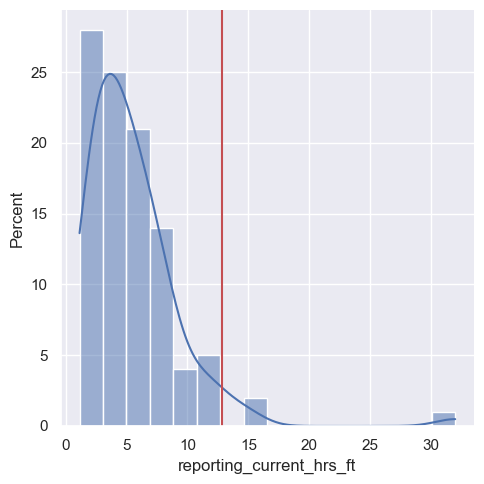

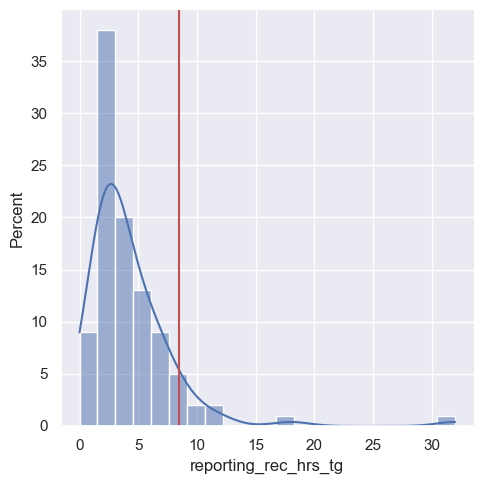

s patient_id                                                           12466
cur_hrs                                                               11.0
rec_hrs                                                               11.0
mean_distance_from_nn                                             2.626103
std_distance_from_nn                                              0.232754
rec_hrs_mean_nn                                                    10.2317
rec_hrs_pct_10_nn                                                    3.004
rec_hrs_pct_25_nn                                                     5.49
rec_hrs_pct_50_nn                                                      9.1
rec_hrs_pct_75_nn                                                  13.7525
rec_hrs_pct_90_nn                                                   18.005
rec_hrs_std_nn                                                    7.172858
rec_hrs_min_nn                                                        1.03
rec_hrs_max_nn         

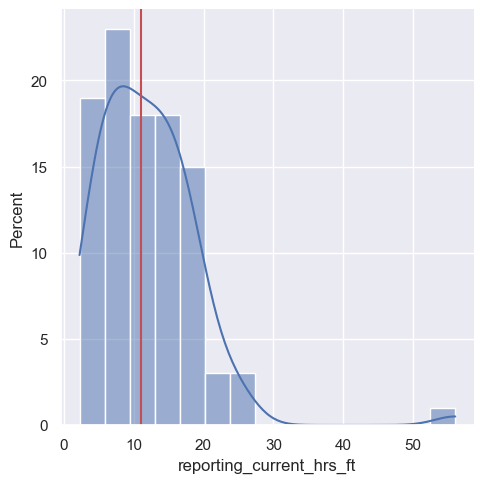

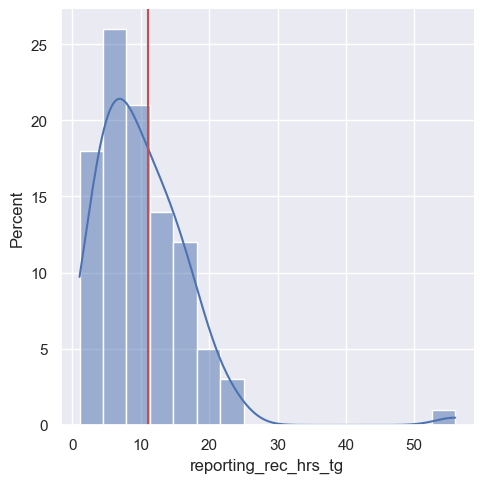

s patient_id                                                           12472
cur_hrs                                                              58.16
rec_hrs                                                              58.16
mean_distance_from_nn                                             4.998666
std_distance_from_nn                                              0.595136
rec_hrs_mean_nn                                                    18.5499
rec_hrs_pct_10_nn                                                    5.631
rec_hrs_pct_25_nn                                                    10.98
rec_hrs_pct_50_nn                                                   15.775
rec_hrs_pct_75_nn                                                  26.0375
rec_hrs_pct_90_nn                                                    32.42
rec_hrs_std_nn                                                   11.147999
rec_hrs_min_nn                                                         0.0
rec_hrs_max_nn         

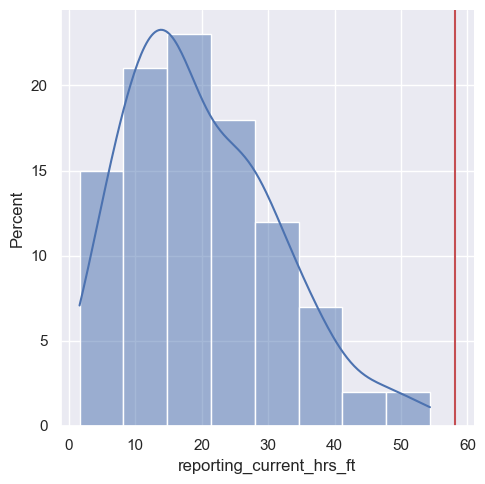

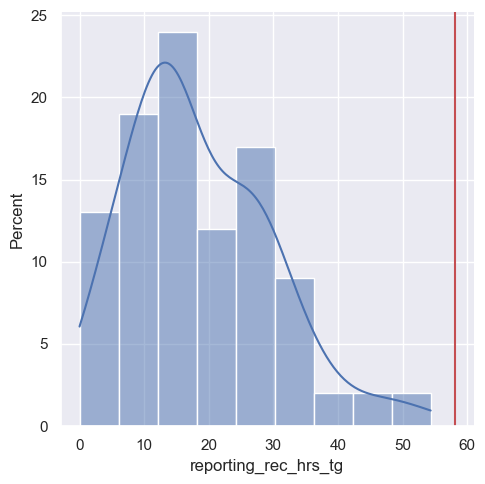

s patient_id                                                           12482
cur_hrs                                                               18.0
rec_hrs                                                               18.0
mean_distance_from_nn                                              3.04418
std_distance_from_nn                                              0.162904
rec_hrs_mean_nn                                                     8.9577
rec_hrs_pct_10_nn                                                     2.39
rec_hrs_pct_25_nn                                                    4.125
rec_hrs_pct_50_nn                                                    7.815
rec_hrs_pct_75_nn                                                  11.3925
rec_hrs_pct_90_nn                                                   15.253
rec_hrs_std_nn                                                    7.231621
rec_hrs_min_nn                                                        1.15
rec_hrs_max_nn         

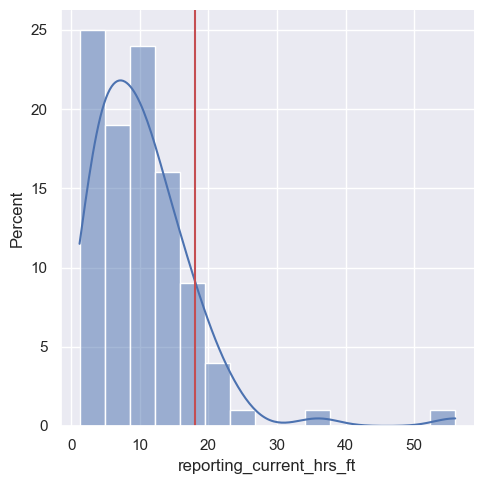

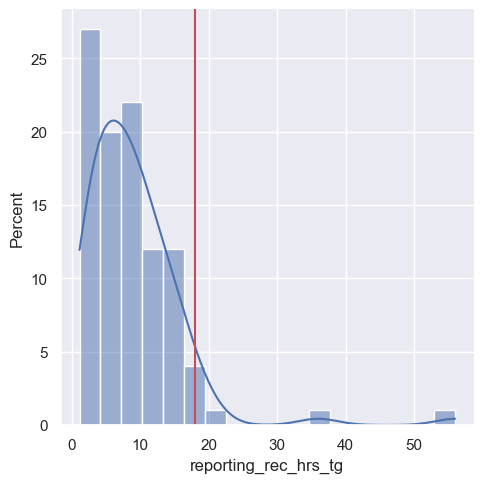

s patient_id                                                           12484
cur_hrs                                                               2.76
rec_hrs                                                               2.18
mean_distance_from_nn                                             5.080957
std_distance_from_nn                                              0.407746
rec_hrs_mean_nn                                                    12.8994
rec_hrs_pct_10_nn                                                    2.635
rec_hrs_pct_25_nn                                                   5.1525
rec_hrs_pct_50_nn                                                    11.26
rec_hrs_pct_75_nn                                                  15.8425
rec_hrs_pct_90_nn                                                   23.162
rec_hrs_std_nn                                                   11.789031
rec_hrs_min_nn                                                         0.0
rec_hrs_max_nn         

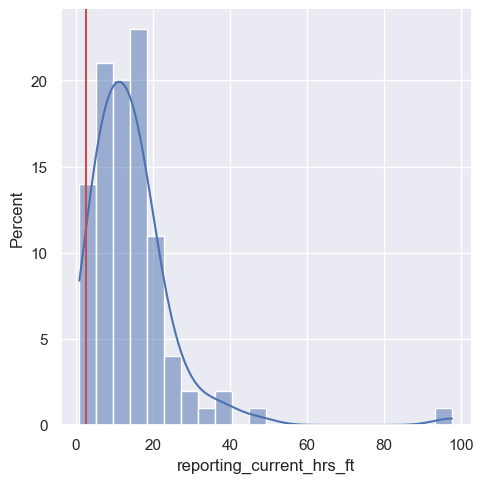

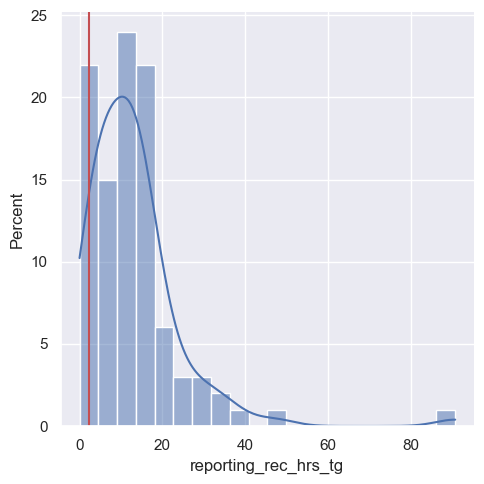

In [119]:
for i, s in nn_100.iterrows():
    print('s', s)
    
    fg = sns.displot(x=s['cur_hrs_from_nn'], kind='hist', kde=True, stat='percent')
    fg.ax.axvline(x = s['cur_hrs'], color = 'r', label = f'Cur Hrs: {s["cur_hrs"]}')
    
    fg = sns.displot(x=s['rec_hrs_from_nn'], kind='hist', kde=True, stat='percent')
    fg.ax.axvline(x = s['rec_hrs'], color = 'r', label = f'Rec Hrs: {s["rec_hrs"]}')
    
    plt.show()
    if i > 10:
        break

In [83]:
build_neighborhood(df, 25)

Percent rec hrs in min max neighbors range: 92.69383697813122
Percent rec hrs in 10-90 neighbors range: 75.19880715705766
Percent rec hrs in 25-75 neighbors range: 47.514910536779325
Total reduction of hrs from recs: 931.1768000000011
Avg reduction of hrs from recs: 0.46281153081510934


,patient_id,cur_hrs,rec_hrs,mean_distance_from_nn,std_distance_from_nn,rec_hrs_mean_nn,rec_hrs_pct_10_nn,rec_hrs_pct_25_nn,rec_hrs_pct_50_nn,rec_hrs_pct_75_nn,rec_hrs_pct_90_nn,rec_hrs_std_nn,rec_hrs_min_nn,rec_hrs_max_nn,rec_hrs_from_nn,distances_from_nn,nn_patient_ids,in_min_max_range,in_10_90_range,in_25_75,hrs_range,mean_err,median_err
0,12450,6.70,5.10,3.630909,0.253787,17.3908,6.452,9.94,14.00,20.32,25.760,16.966045,0.57,90.63,32 11.49 52 16.15 56 8.39 113 ...,"[3.0661231402393327, 3.079682523320293, 3.2188...","[18567, 15288, 22787, 19243, 19857, 15319, 163...",1,0,0,90.06,12.2908,8.90
1,12454,5.06,4.08,3.620007,0.515442,5.1424,2.300,2.59,4.02,6.03,10.566,3.616078,2.07,14.66,43 5.08 60 14.37 91 2.30 95 ...,"[2.039607805437114, 2.179704363236241, 2.67415...","[12658, 12907, 15071, 12778, 13148, 22787, 133...",1,1,1,12.59,1.0624,0.06
2,12455,13.62,10.23,1.968819,0.170543,8.6864,2.990,4.60,7.53,11.09,17.468,5.272114,1.15,19.00,40 7.53 67 8.00 147 5.52 150 ...,"[1.6944353369518441, 1.72272394125634, 1.73333...","[19108, 13184, 13285, 16338, 15152, 13254, 126...",1,1,1,17.85,1.5436,2.70
3,12458,29.37,29.37,4.261395,0.319343,15.2124,6.452,11.09,13.56,16.03,27.318,7.659122,4.50,32.00,12 30.75 20 27.00 28 14.48 31 ...,"[3.640054944640259, 3.678918923331206, 3.80847...","[12511, 23200, 13291, 12834, 12993, 22949, 124...",1,0,0,27.50,14.1576,15.81
4,12459,35.00,32.42,3.295712,0.359841,17.0908,8.528,13.10,16.95,20.32,26.668,7.163189,1.03,27.82,18 19.42 27 10.46 47 26.81 52 ...,"[2.154065922853802, 2.8759539480163987, 2.8965...","[13134, 14330, 13328, 12544, 14262, 13420, 127...",0,0,0,26.79,15.3292,15.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,31770,24.25,19.54,2.580582,0.262754,9.3404,2.760,4.60,7.95,10.92,18.340,6.243396,1.55,25.80,35 5.17 81 9.94 112 10.80 189 ...,"[1.8330302779823358, 2.237061564741669, 2.2370...","[19044, 16752, 19352, 16943, 15018, 15989, 230...",1,0,0,24.25,10.1996,11.59
2008,31777,3.22,1.15,1.670074,0.254838,3.3852,1.472,2.07,3.05,3.79,6.474,2.013939,1.15,9.25,258 5.00 407 7.00 483 2.07 577 ...,"[1.0088497300281034, 1.1333333333333326, 1.280...","[22585, 17731, 15026, 23500, 16341, 22943, 316...",1,0,0,8.10,2.2352,1.90
2009,34160,2.87,2.30,1.854252,0.168566,4.5584,1.720,2.70,3.95,6.03,8.258,2.658583,1.00,11.23,300 11.23 395 4.60 498 3.45 577 ...,"[1.4696938456699067, 1.5362291495737215, 1.563...","[19820, 22629, 14960, 19708, 22603, 23562, 228...",1,1,0,10.23,2.2584,1.65
2010,34178,5.57,4.60,2.549924,0.174419,4.4748,1.508,2.59,3.51,5.00,8.618,3.188149,1.00,15.23,308 1.24 328 4.23 428 2.59 522 ...,"[2.0947023124486632, 2.1, 2.3154073315749675, ...","[13604, 16089, 23400, 17051, 22682, 17667, 230...",1,1,1,14.23,0.1252,1.09


### Prep for Sagemaker Training/Deploy
Format: target in col one, then features 

Will make the current hrs feature last so that it is easy to remove

In [ ]:
ordered_cols = ['reporting_rec_hrs_tg'] + features + ['reporting_current_hrs_ft']
ordered_cols

In [ ]:
training_data_file = '../data/itc_training_data_20230127.csv'
df[['reporting_rec_hrs_tg'] + features + ['reporting_current_hrs_ft']].to_csv(training_data_file, index=False, header=False)

In [ ]:
import boto3
from time import gmtime, strftime

In [ ]:
s3 = boto3.client('s3')

bucket = 'cb-analytics-us-east-2-prd'
prefix = 'sagemaker/training_data'
key = f'{prefix}/{strftime("%Y%m%d%H%M%S", gmtime())}_itc_traning_data.csv'

s3.upload_file(training_data_file, bucket, key, ExtraArgs={'ServerSideEncryption': 'AES256'})
key

### Sagemaker Training
Broken out into separate notebook that needs to be run on a sagemaker notebook instance in the aws console

In [ ]:
raise "Stop"

In [ ]:
# TODO clean up the following pulled from previous NB

### Check random patient's neighbors
In practice could show top 10 most similar patients

In [ ]:
pid = nn_df.patient_id.sample().values[0]
pid_neighbors = df.loc[df.patient_id.isin(neighbors[pid])]
print(f'Patient id {pid}, neighbor mean/range: {pid_neighbors.reporting_rec_hrs.mean()}; {pid_neighbors.reporting_rec_hrs.min()} - {pid_neighbors.reporting_rec_hrs.max()}')
pid_neighbors 